In [1]:
# Limit GPU ram usage for multiple models
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import layers
from keras import optimizers

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import cv2
import os

import numpy as np

In [3]:
labels = ['up_arrow', 'left_arrow', 'down_arrow', 'right_arrow']

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                # Read in and set to grayscale
                img_arr = cv2.cvtColor(cv2.imread(os.path.join(path, img)), cv2.COLOR_BGR2GRAY)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
data = get_data('processed-images')

<ipython-input-3-0ade627b99dc>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


C:\Users\johna\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

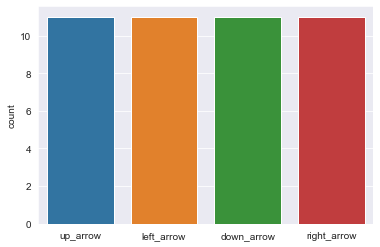

In [5]:
l = []
for i in data:
    if(i[1] == 0):
        l.append(labels[0])
    elif(i[1] == 1):
        l.append(labels[1])
    elif(i[1] == 2):
        l.append(labels[2])
    else:
        l.append(labels[3])
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'up_arrow')

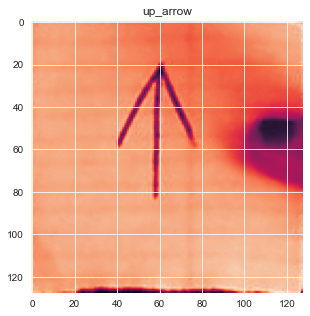

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(data[1][0])
plt.title(labels[data[0][1]])

In [7]:
# Split into a training and validation set
X = []
y = []

for feature, label in data:
  X.append(feature)
  y.append(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
# Normalize the data
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_train = X_train.reshape(X_train.shape[0], 128,128,1)
X_test = X_test.reshape(X_test.shape[0], 128,128,1)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35, 128, 128, 1)
(35,)
(9, 128, 128, 1)
(9,)


In [9]:
# TODO:
# Make images much more clear, sharpen center symbol and attempt to make background completely blank

In [10]:
# One-hot encoding
print("Shape before one-hot encoding: ", y_train.shape)
y_train = np_utils.to_categorical(y_train, len(labels))
y_test = np_utils.to_categorical(y_test, len(labels))
print("Shape after one-hot encoding: ", y_train.shape)

Shape before one-hot encoding:  (35,)
Shape after one-hot encoding:  (35, 4)


In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential()

model.add(layers.Conv2D(128, (12, 12), activation='relu', strides=(2,2), padding='valid', input_shape=(128, 128, 1)))
model.add(layers.Conv2D(256, (5, 5), activation='relu', strides=(1,2), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(len(labels)))

model.compile(optimizers.Adam(learning_rate=0.005, beta_1=0.95),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 59, 59, 128)       18560     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 30, 256)       819456    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 15, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 111360)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              114033664 
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 114,875,780
Trainable params: 114,875,780
Non-trainable params: 0
__________________________________________

In [13]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
3/3 [==============================] - 4s 647ms/step - loss: 598.4865 - accuracy: 0.1795 - val_loss: 65.9644 - val_accuracy: 0.2222
Epoch 2/10
3/3 [==============================] - 0s 55ms/step - loss: 51.6048 - accuracy: 0.3368 - val_loss: 17.2432 - val_accuracy: 0.2222
Epoch 3/10
3/3 [==============================] - 0s 55ms/step - loss: 15.1059 - accuracy: 0.1717 - val_loss: 1.8112 - val_accuracy: 0.2222
Epoch 4/10
3/3 [==============================] - 0s 55ms/step - loss: 1.5413 - accuracy: 0.3069 - val_loss: 1.4097 - val_accuracy: 0.2222
Epoch 5/10
3/3 [==============================] - 0s 56ms/step - loss: 2.1481 - accuracy: 0.3290 - val_loss: 1.4443 - val_accuracy: 0.2222
Epoch 6/10
3/3 [==============================] - 0s 55ms/step - loss: 1.8120 - accuracy: 0.2913 - val_loss: 1.7135 - val_accuracy: 0.2222
Epoch 7/10
3/3 [==============================] - 0s 56ms/step - loss: 1.7885 - accuracy: 0.3263 - val_loss: 1.4920 - val_accuracy: 0.2222
Epoch 8/10
3/3 [====

1/1 - 0s - loss: 2.0156 - accuracy: 0.2222
0.2222222238779068


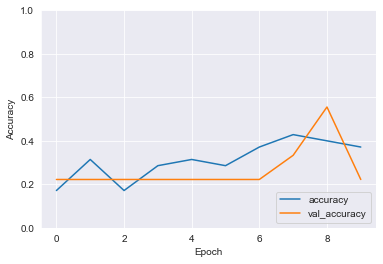

In [14]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)